### Target:

- Fix dropout, alter max pool

### Results:

- Parameters: 7,884
- Best Training Accuracy: 99.34
- Best Test Accuracy: 99.36

### Analysis:
- Model is consistently achieving 99.2+ accuracy on 10 epochs onwards
- No max pool alteration is done.
- Removing droupt has increased the accuracy from 99.23(previous training) to 99.36(current training)
- Model can be pushed further

# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7']


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3105,))
    ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


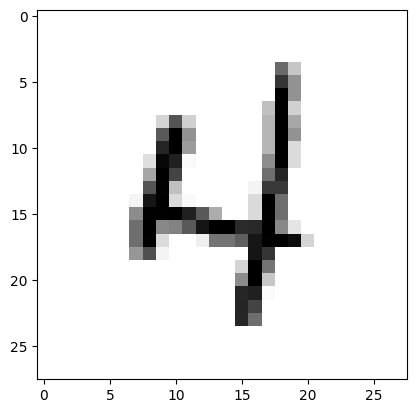

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [ ]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)
exp_data = exp.test_data
exp_data = exp.transform(exp_data.numpy())

print('[Test]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

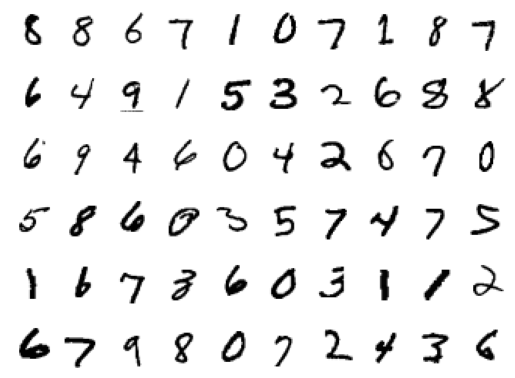

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
from models import Model8 as Net ,get_summary


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
           Conv2d-10           [-1, 10, 20, 20]             900
      BatchNorm2d-11           [-1, 10, 20, 20]              20
           Conv2d-12           [-1, 10, 20, 20]             100
      BatchNorm2d-13           [-1, 10, 20, 20]              20
        MaxPool2d-14           [-1, 10,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [ ]:
model =  Net(dropout_value=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,None)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

EPOCH: 0


Loss=0.14126406610012054 Batch_id=468 Accuracy=95.19: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]



Test set: Average loss: 0.0848, Accuracy: 9856/10000 (98.56%)

EPOCH: 1


Loss=0.12363556772470474 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]



Test set: Average loss: 0.0596, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.06801901012659073 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.0495, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.07147563993930817 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0457, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.01678154431283474 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]



Test set: Average loss: 0.0360, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.053118374198675156 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0330, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.03199395537376404 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]



Test set: Average loss: 0.0347, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.013473834842443466 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]



Test set: Average loss: 0.0310, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.07528478652238846 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]



Test set: Average loss: 0.0282, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.01974247582256794 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0300, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.026079343631863594 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]



Test set: Average loss: 0.0355, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.049053534865379333 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0296, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.014930526725947857 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]



Test set: Average loss: 0.0313, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.020971029996871948 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]



Test set: Average loss: 0.0274, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.04969988390803337 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]



Test set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)



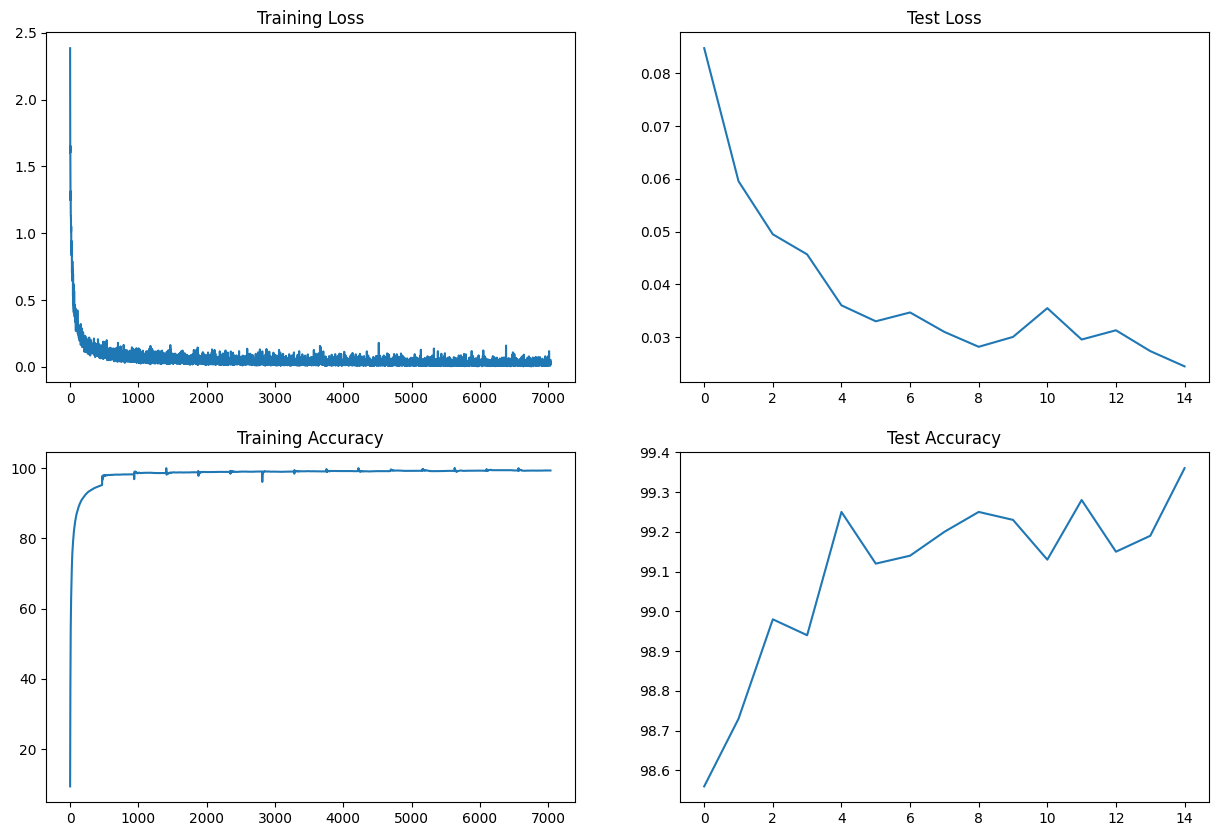

In [ ]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)